In [1]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

## Минипроект

Опираясь на [карту](https://eusipa.org/wp-content/uploads/European_map_20160530_2016.pdf) Европейской ассоциации структурных инвестиционных
продуктов (EUSIPA) и ее [российскую адаптацию](https://naufor.ru/tree.asp?n=22890)

привести 2-3 ссылки на

*   структурные продукты, представленные на россиском рынке,
*   доступные наборы данных (напрмер, [HKEX](https://www.hkex.com.hk/Products/Securities/Structured-Products/Trading-Information-and-Historical-Data?sc_lang=en)).

# Cтруктурный продукт с полной защитой капитала

## СП с использованием бинарных опционов

Пример. Имеется 0,1 млн рублей, которые клиент готов инвестировать на 1 год. Ожидается, что текущая цена акции, равная 100 руб., не изменится более чем на 10%. Волатильность акции – 30%, депозитная процентная ставка и безрисковая процентная
ставка – 7%.

Постройте структурный продукт с полной защитой капитала и использованием опционной стратегии бинарный диапазон (binary range).

In [3]:
# оценка стоимости бинарного опциона колл
def binary_option_call(t, S, K, T, r, q, sigma):

    d1 = (np.log(S/K) + (r+sigma**2/2)*(T))/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    if t == 'cash-or-nothing':
      return np.exp(-r*T)*norm.cdf(d2)
    if t == 'asset-or-nothing':
      return S*np.exp(-q*T)*norm.cdf(d1)

# оценка стоимости бинарного опциона пут
def binary_option_put(t, S, K, T, r, q, sigma):
    d1 = (np.log(S/K) + (r+sigma**2/2)*(T))/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    if t == 'cash-or-nothing':
      return np.exp(-r*T)*norm.cdf(-d2)
    if t == 'asset-or-nothing':
      return S*np.exp(-q*T)*norm.cdf(-d1)

In [4]:
S = 100
K = 100
T = 1
r = 0.07
q = 0
N = 100000
sigma = 0.3
n = 100

In [5]:
K=90
b90 = binary_option_call('cash-or-nothing', S, K, T, r, q, sigma)
K=110
b110 = binary_option_call('cash-or-nothing', S, K, T, r, q, sigma)
print('digital range = ', b90-b110)

digital range =  0.24307515482345715


In [6]:
risk_part = N - N*np.exp(-r*T)
Q = round(risk_part/(b90-b110))
print('количество опционных стратегий', Q)

количество опционных стратегий 27813


In [7]:
print('максимальная доходность, годовых = ', (N+Q)/(N*T)-1)
print('максимальная доходность, непрерывно = ', np.log((N+Q)/(N*T)))

максимальная доходность, годовых =  0.27813
максимальная доходность, непрерывно =  0.24539807222181784


In [8]:
def call(S, K, T, sigma, r, q):
    d1 = (np.log (S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp (-r * T) * norm.cdf(d2)

Пример. Постройте график доходности структурного продукта в сравнении с доходностью базового актива и безрисковой ставки.

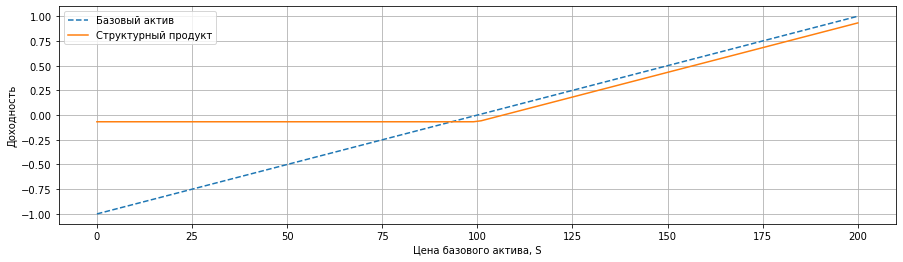

In [9]:
risk_part = N - N * np.exp(-r * T)
c = call(S, K, T, sigma, r, q)
PR = S * round(risk_part / c) / N

underlying_asset_profit = np.linspace(- S, S, n) / S
struct_product_profit = np.maximum(0, underlying_asset_profit) - round(risk_part / c) * c / N

x = np.linspace(0, 2 * S, n)
plt.figure(figsize=(15, 4))
#plt.title('Profit UA vs OC')
plt.plot(x, underlying_asset_profit, '--', label='Базовый актив')
plt.plot(x, struct_product_profit,  label='Структурный продукт')
plt.ylabel('Доходность')
plt.xlabel('Цена базового актива, S')
plt.grid()
plt.legend()
plt.show()

Пример. Постройте график зависимости коэффициента участия от встроенной комиссии, проварьируйте комиссию от 0 до 10% с шагом 1%.

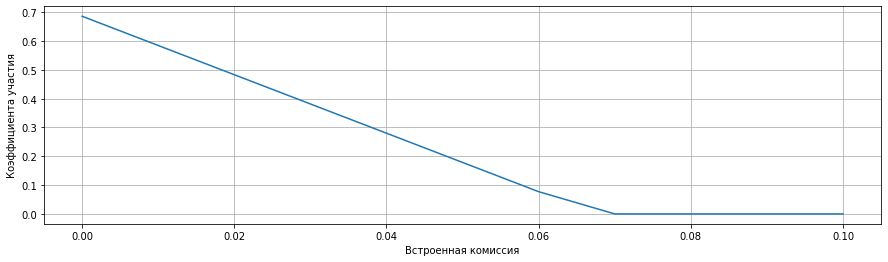

In [10]:
da = np.exp(-r * T) * N

Q = lambda fees: ( N * (1 - fees)  - da ) / c
fees = (np.linspace(0.0, 0.1, 11))
PR = K * Q(fees) / N

plt.figure(figsize=(15, 4))
#plt.title('PR from fees value')
plt.plot(fees, np.maximum(PR, 0))
plt.xlabel('Встроенная комиссия')
plt.ylabel('Коэффициента участия')
plt.grid()
plt.show()

Постройте график зависимости коэффициента участия от процентных ставок (депозитная и безрисковая ставки равны), проварьируйте ставки от 0 до 20% с шагом 1%.

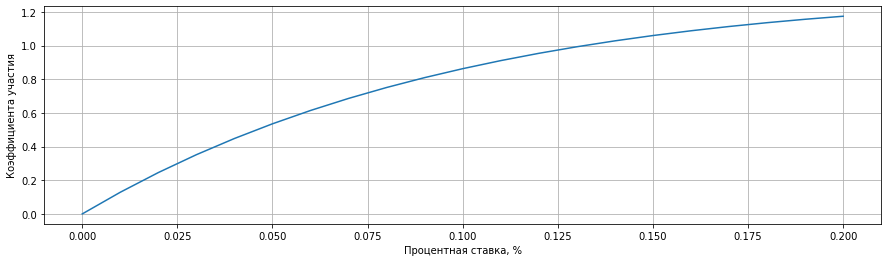

In [11]:
Q = lambda da, c: ( N * (1 - 0.0)  - da ) / c
rs = np.linspace(0, 0.2, 21)
cs = np.fromiter((call(S, K, T, sigma, ri, q) for ri in rs), dtype=np.float32)
das = np.exp(-rs * T) * N
Qs = np.fromiter((Q(da,c) for da,c in zip(das, cs)), dtype=np.float32)
PR = K * Qs / N

plt.figure(figsize=(15, 4))
#plt.title('PR from interest rate')
plt.plot(rs, np.maximum(PR, 0))
plt.xlabel('Процентная ставка, %')
plt.ylabel('Коэффициента участия')
plt.grid()
plt.show()

### Задача

Задача. Постройте трехмерных график зависимости коэффициента участия от депозитной и безрисковой ставок, проварьируйте ставки от 0 до 25% с шагом 1%.

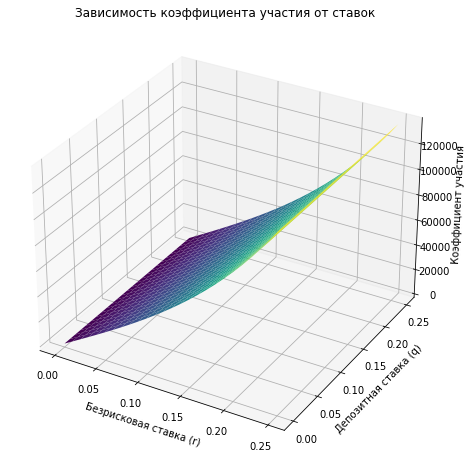

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Функция для расчета стоимости бинарного опциона колл
def binary_option_call(t, S, K, T, r, q, sigma):
    d1 = (np.log(S/K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if t == 'cash-or-nothing':
        return np.exp(-r * T) * norm.cdf(d2)
    if t == 'asset-or-nothing':
        return S * np.exp(-q * T) * norm.cdf(d1)

# Параметры
S = 100  # Цена базового актива
K = 100  # Страйк
T = 1    # Время до экспирации
sigma = 0.3  # Волатильность
q = 0    # Дивидендная доходность
N = 100000  # Сумма инвестиций

# Функция для расчета коэффициента участия
def participation_rate(r, q, N, T, S, K, sigma):
    b90 = binary_option_call('cash-or-nothing', S, 90, T, r, q, sigma)
    b110 = binary_option_call('cash-or-nothing', S, 110, T, r, q, sigma)
    risk_part = N - N * np.exp(-r * T)
    Q = risk_part / (b90 - b110)
    return Q

# Варьируем ставки
rs = np.linspace(0, 0.25, 26)
qs = np.linspace(0, 0.25, 26)

# Создаем сетку для 3D графика
R, Q = np.meshgrid(rs, qs)
Z = np.array([[participation_rate(r, q, N, T, S, K, sigma) for r, q in zip(r_row, q_row)] for r_row, q_row in zip(R, Q)])

# Строим график
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(R, Q, Z, cmap='viridis')

ax.set_xlabel('Безрисковая ставка (r)')
ax.set_ylabel('Депозитная ставка (q)')
ax.set_zlabel('Коэффициент участия')
ax.set_title('Зависимость коэффициента участия от ставок')

plt.show()


Пример. Постройте график зависимости коэффициента участия от волатильности базового актива, проварьируйте волатильность от 0 до
100% с шагом 5%.

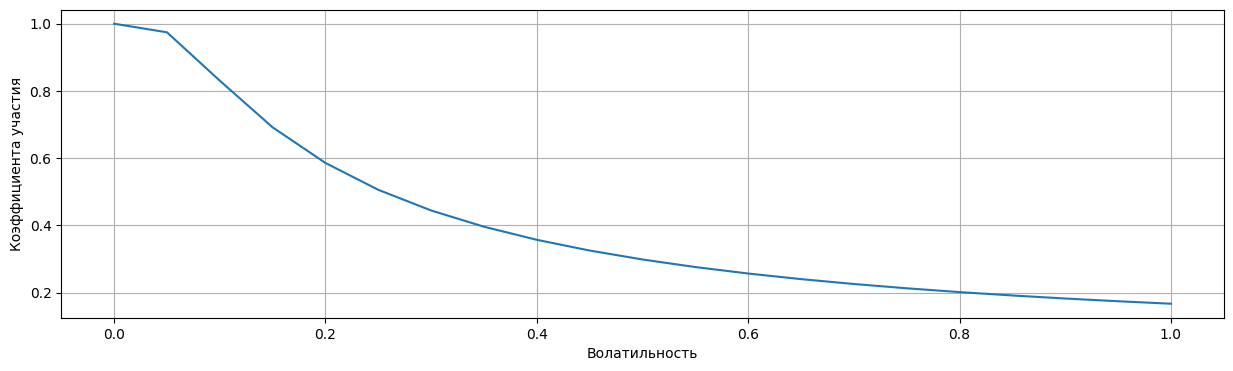

In [ ]:
vs = np.linspace(1e-5, 1, 21)
cs = call(S, K, T, vs, r, q)
da = np.exp(-r * T) * N
Q = lambda c: ( N * (1 - 0.0)  - da ) / c
Qs = Q(cs)
PR = K * Qs / N

plt.figure(figsize=(15, 4))
#plt.title('PR from volatility')
plt.plot(vs, PR)
plt.xlabel('Волатильность')
plt.ylabel('Коэффициента участия')
plt.grid()
plt.show()

Пример. Постройте график влияния срока продукта (от 0 до 100 лет, с
шагом 6 месяцев) на соотношение безрискового и рискового вложений.

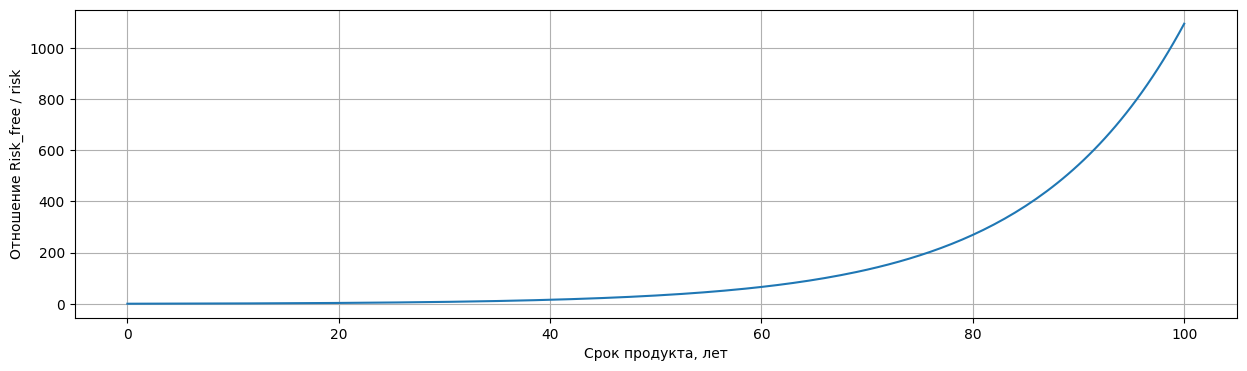

In [ ]:
Ts = np.linspace(1e-5, 100, 201)
risk_parts = N - N * np.exp(-r * Ts)
ratios = risk_parts / (N - risk_parts)

plt.figure(figsize=(15, 4))
#plt.title('Risk-free to risk fraction relation on maturity date')
plt.plot(Ts, ratios)
plt.xlabel('Срок продукта, лет')
plt.ylabel('Отношение Risk_free / risk')
plt.grid()
plt.show()

Пример. Постройте график зависимости коэффициента участия от срока
продукта (от 0 до 20 лет, с шагом 6 месяцев).


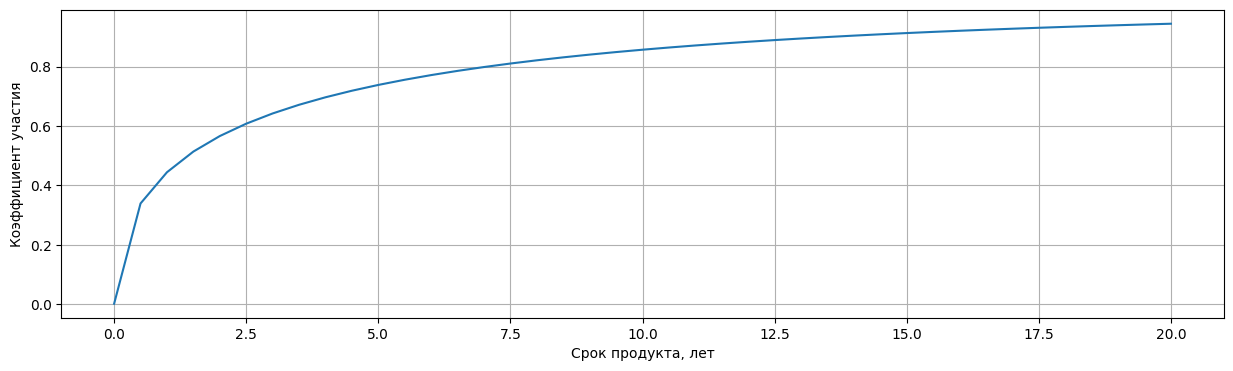

In [ ]:
Ts = np.linspace(1e-5, 20, 41)
cs = call(S, K, Ts, sigma, r, q)
das = np.exp(-r * Ts) * N
Q = lambda c, d: ( N * (1 - 0.0)  - d ) / c
Qs = np.fromiter((Q(c, d) for c,d in zip(cs, das)), dtype=np.float64)
PR = K * Qs / N

plt.figure(figsize=(15, 4))
#plt.title('PR from maturity date')
plt.plot(Ts, PR)
plt.xlabel('Срок продукта, лет')
plt.ylabel('Коэффициент участия')
plt.grid()
plt.show()

Пример. Постройте график коэффициента участия от страйка продукта
(от 80 до 140, с шагом 10).

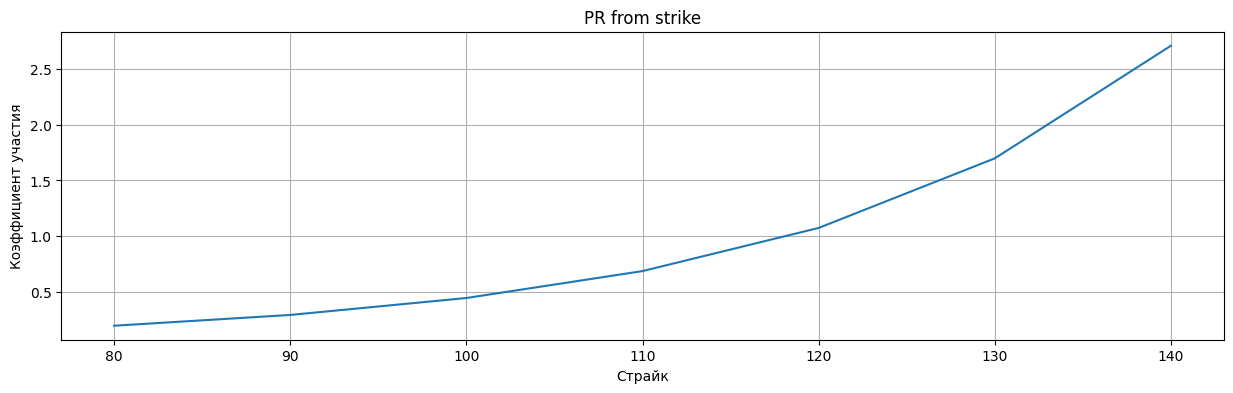

In [ ]:
Ks = np.linspace(80, 140, 7)
cs = call(S, Ks, T,  sigma, r, q)
da = np.exp(-r * T) * N
Q = lambda c: ( N * (1 - 0.0)  - da ) / c
Qs = Q(cs)
PR = np.fromiter(((Kv * Qv / N) for Kv, Qv in zip(Ks, Qs)), dtype=np.float32)

plt.figure(figsize=(15, 4))
#plt.title('PR from strike')
plt.plot(Ks, PR)
plt.xlabel('Страйк')
plt.ylabel('Коэффициент участия')
plt.grid()
plt.show()

Пример. Постройте график доходности продуктов с разными страйками и
100% защитой капитала.

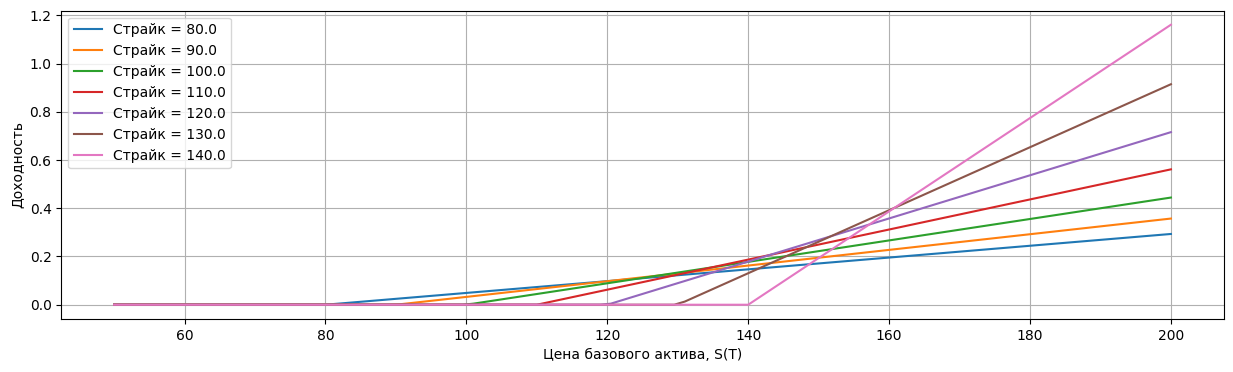

In [ ]:
Ks = np.linspace(80, 140, 7)

cs = call(S, Ks, T, sigma, r, q)
da = np.exp(-r * T) * N
Q = lambda c: ( N * (1 - 0.0)  - da) / c
Qs = Q(cs)
# Qs = np.fromiter((Q(c) for c in zip(cs, das)), dtype=np.float64)
PR = np.fromiter(((Kv * Qv / N) for Kv, Qv in zip(Ks, Qs)), dtype=np.float32)
Sm = np.linspace(0.5*S, 2*S, 101)

plt.figure(figsize=(15, 4))
#plt.title('Profit on UA')
for i, pr in enumerate(PR):
    rs = np.maximum(0, pr * (Sm - Ks[i]) / Ks[i])
    plt.plot(Sm, rs, label=f'Страйк = {Ks[i]}')
plt.xlabel('Цена базового актива, S(T)')
plt.ylabel('Доходность')
plt.legend()
plt.grid()
plt.show()

Пример. Постройте графики доходностей продуктов с одним страйком и
разной степенью защиты капитала (от 80% до 150%, с шагом 10%)

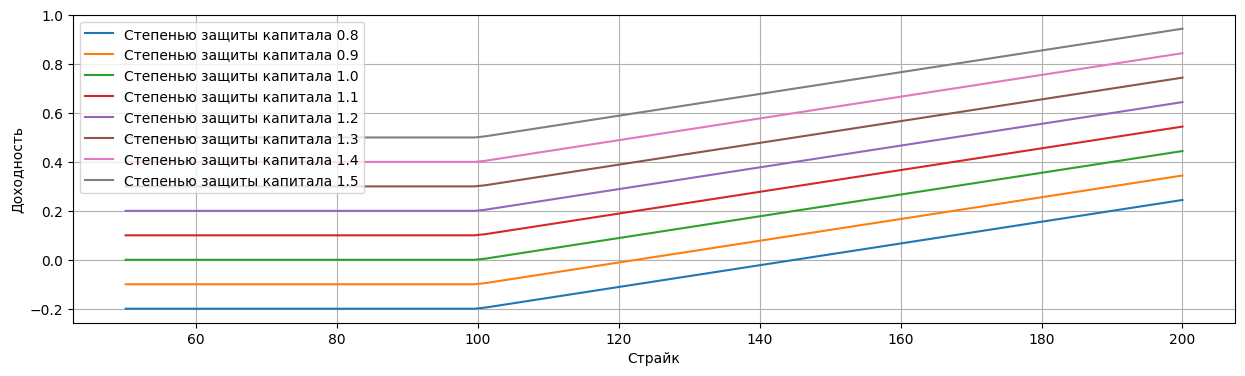

In [ ]:
gs = np.linspace(0.8, 1.5, 8)
c = call(S, K, T, sigma, r, q)
da = np.exp(-r * T) * N
Q = lambda c: ( N * (1 - 0.0)  - da ) / c
PR = K * Q(c) / N
Sm = np.linspace(0.5*S, 2*S, 101)

plt.figure(figsize=(15, 4))
#plt.title('PR from strike')
for i, g in enumerate(gs):
    returns = np.maximum(g - 1, (g - 1) + PR * (Sm - S)/S)
    plt.plot(Sm, returns, label=f'Степенью защиты капитала {g}')
plt.xlabel('Страйк')
plt.ylabel('Доходность')
plt.legend()
plt.grid()
plt.show()

### Задача

Задача. В условиях примера постройте 3D график зависимости доходности структурного продукта от

*   страйков и
*   степени защиты капитала.

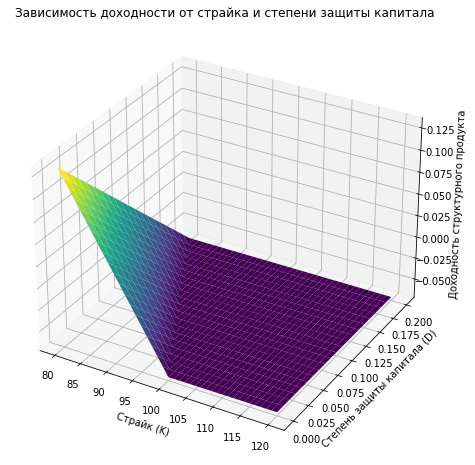

In [13]:
# Функция для расчета доходности структурного продукта
def struct_product_profit(S, K, T, sigma, r, q, N, D):
    b90 = binary_option_call('cash-or-nothing', S, 90, T, r, q, sigma)
    b110 = binary_option_call('cash-or-nothing', S, 110, T, r, q, sigma)
    risk_part = N - N * np.exp(-r * T)
    Q = risk_part / (b90 - b110)
    
    # Применение степени защиты капитала D
    S_final = S * (1 - D)
    return np.maximum(0, (S_final - K) / S) - Q * (b90 - b110) / N

# Варьируем страйк и степень защиты капитала
K_values = np.linspace(80, 120, 41)
D_values = np.linspace(0, 0.2, 21)

# Создаем сетку для 3D графика
K_grid, D_grid = np.meshgrid(K_values, D_values)
Z = np.array([[struct_product_profit(S, K, T, sigma, r, q, N, D) for K, D in zip(k_row, d_row)] for k_row, d_row in zip(K_grid, D_grid)])

# Строим график
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K_grid, D_grid, Z, cmap='viridis')

ax.set_xlabel('Страйк (K)')
ax.set_ylabel('Степень защиты капитала (D)')
ax.set_zlabel('Доходность структурного продукта')
ax.set_title('Зависимость доходности от страйка и степени защиты капитала')

plt.show()


Пример. В условиях примера для опциона колл повторите все расчеты с использованием бинарной стратегии, основанной на покупке и продаже европейского опциона пут.

Ширину диапазона доходности базового актива задать самостоятельно. Выбор обосновать.

In [ ]:
S = 100
K = 100
T = 1
r = 0.07
q = 0
N = 100000
sigma = 0.3

K1 = 100
bo1 = binary_option_put('cash-or-nothing', S, K1, T, r, q, sigma)
K2=110
bo2 = binary_option_put('cash-or-nothing', S, K2, T, r, q, sigma)
print('digital range = ', -bo1+bo2)

risk_part = N - N*np.exp(-r*T)
Q = round(risk_part/(-bo1+bo2))
print('количество опционных стратегий', Q)

print('максимальная доходность, годовых = ', (N+Q)/(N*T)-1)
print('максимальная доходность, непрерывно = ', np.log((N+Q)/(N*T)))

digital range =  0.11734811871736428
количество опционных стратегий 57612
максимальная доходность, годовых =  0.57612
максимальная доходность, непрерывно =  0.45496613066900204


Пример. Постройте график функции выплат для бинарных стратегий, основанных
*   на покупке и продаже опционов колл,
*  на покупке и продаже опционов пут.



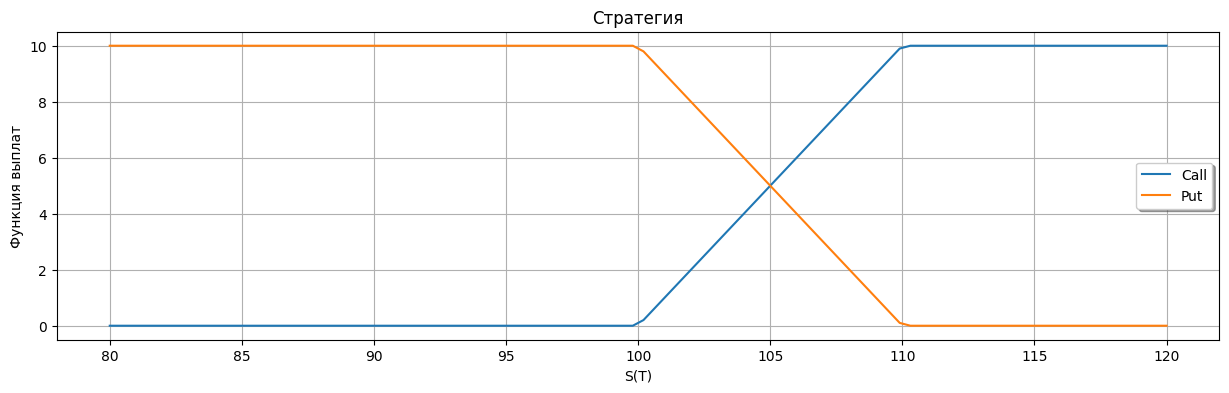

In [ ]:
S = np.linspace(80, 120, 100)

C1 = np.maximum(S - K1, 0)
C2 = np.maximum(S - K2, 0)

P1 = np.maximum(-S + K1, 0)
P2 = np.maximum(-S + K2, 0)
plt.figure(figsize=(15,4))
plt.plot(S, C1 - C2, label=f'Call')
plt.plot(S, -P1 + P2, label=f'Put')
plt.legend(loc = 'best', fancybox = True, shadow = True)

plt.xlabel(f"S(T)")
plt.ylabel("Функция выплат")
plt.title("Стратегия")

plt.grid(True)
plt.show()

### Задача

Задача. Постройте графики трехмерных поверхностей для описания зависимости коэффициента участия при использовании бинарных опционов  
*   кол,
*   пут

от стоимости базового актива и количества дней до экспирации.

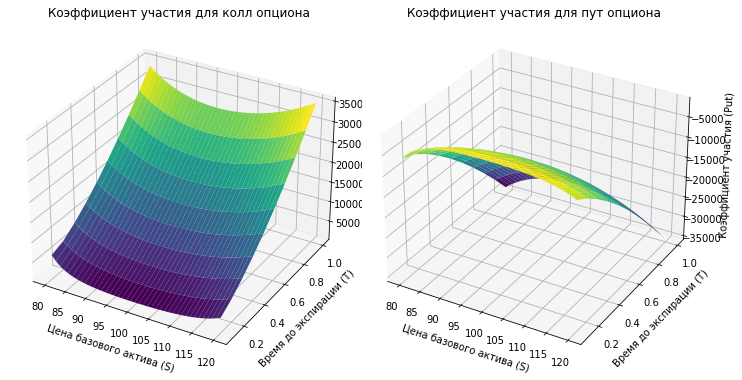

In [14]:
# Функция для расчета коэффициента участия для колл опциона
def participation_rate_call(S, T, r, q, sigma, N):
    b90 = binary_option_call('cash-or-nothing', S, 90, T, r, q, sigma)
    b110 = binary_option_call('cash-or-nothing', S, 110, T, r, q, sigma)
    risk_part = N - N * np.exp(-r * T)
    Q = risk_part / (b90 - b110)
    return Q

# Функция для расчета коэффициента участия для пут опциона
def participation_rate_put(S, T, r, q, sigma, N):
    b90 = binary_option_put('cash-or-nothing', S, 90, T, r, q, sigma)
    b110 = binary_option_put('cash-or-nothing', S, 110, T, r, q, sigma)
    risk_part = N - N * np.exp(-r * T)
    Q = risk_part / (b90 - b110)
    return Q

# Варьируем цену актива и количество дней до экспирации
S_values = np.linspace(80, 120, 41)
T_values = np.linspace(0.1, 1, 10)

# Создаем сетку для 3D графика
S_grid, T_grid = np.meshgrid(S_values, T_values)
Z_call = np.array([[participation_rate_call(S, T, r, q, sigma, N) for S, T in zip(s_row, t_row)] for s_row, t_row in zip(S_grid, T_grid)])
Z_put = np.array([[participation_rate_put(S, T, r, q, sigma, N) for S, T in zip(s_row, t_row)] for s_row, t_row in zip(S_grid, T_grid)])

# Строим график для колл опциона
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(S_grid, T_grid, Z_call, cmap='viridis')

ax.set_xlabel('Цена базового актива (S)')
ax.set_ylabel('Время до экспирации (T)')
ax.set_zlabel('Коэффициент участия (Call)')
ax.set_title('Коэффициент участия для колл опциона')

# Строим график для пут опциона
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(S_grid, T_grid, Z_put, cmap='viridis')

ax2.set_xlabel('Цена базового актива (S)')
ax2.set_ylabel('Время до экспирации (T)')
ax2.set_zlabel('Коэффициент участия (Put)')
ax2.set_title('Коэффициент участия для пут опциона')

plt.tight_layout()
plt.show()


## CП с использованием гэп опционов

### Задача

Задача. Рассмотрим гэп опционы колл и пут на недивидендные акции со страйком 57 и сроком действия, истекающим 1 июля следующего года, на 1 января текущего года акции торгуются по цене 50.

Используя эти данные, вычислите цену опциона колл и пут, если безрисковая ставка равна 9%, цена страйк 50, волатильность 20%.

In [15]:
import numpy as np
from scipy.stats import norm

# Параметры задачи
S0 = 50  # Текущая цена
K = 57    # Страйк
T = 1     # Срок до экспирации (в годах)
r = 0.09  # Безрисковая ставка
sigma = 0.2  # Волатильность

# Функции для расчета цен опционов
def black_scholes_call(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_put(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)

# Рассчитываем цену колл и пут
call_price = black_scholes_call(S0, K, T, r, sigma)
put_price = black_scholes_put(S0, K, T, r, sigma)

print("Цена колл опциона: ", call_price)
print("Цена пут опциона: ", put_price)


Цена колл опциона:  3.1041086009838317
Цена пут опциона:  5.198186161443836


В рамках модели Блэка-Шоулза решите следующие задачи для бинарных опционов.

Пример. Маркет-мейкер продает европейские гэп-колл опционы сумму 1000 сроком на один год и дельта-хеджирует позицию акциями.
Опцион гэп-колл выписан на одну акцию, не приносящую дивидендов. Текущая цена акции составляет 100.

Волатильность акции составляет 100\%. Каждый колл-гэп опцион  имеет цену исполнения 130, триггер цена равна  100. Безрисковая процентная ставка равна 0\%.

В рамках модели Блэка-Шоулза определите начальное количество акций для  дельта-хеджирования.

**Указание.** Определите дельту опциона и умножьте на 1000.

In [18]:
def gap_option_price_call(S, K1, K2, T, r, q, sigma):
    d1 = (np.log(S / K2) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return np.exp(-r * T) * norm.cdf(d1) - np.exp(-r * T) * norm.cdf(d2)

def first_derivative (f , x , args, h = 0.0001) :
    return (f(x + h, *args) - f(x - h, *args)) / (2 * h)

# Параметры задачи
S = 100
K1 = 130  # страйк
K2 = 100  # триггер
r = 0.0
sigma = 1.0
T = 1
q = 0

# Расчет дельты
delta = first_derivative(gap_option_price_call, S, (K1, K2, T, r, q, sigma))
delta_value = round(delta * 1000)

print("Цена гэп-колл опциона: ", gap_option_price_call(S, K1, K2, T, r, q, sigma))
print("Начальное количество акций для дельта-хеджирования: ", delta_value)


Цена гэп-колл опциона:  0.38292492254802624
Начальное количество акций для дельта-хеджирования:  0


In [19]:
S = 100
K1 = 130 # strike
K2 = 100 # trigger
r = 0.0
sigma = 1
T = 1
q = 0

c = gap_option_price_call(S, K1, K2, T, r, q, sigma)
delta = first_derivative(gap_option_price_call, S, (K1, K2, T, r, q, sigma))
c, round(delta * 1000)

(0.38292492254802624, 0)

### Задача

Задача. В условиях примера определите начальное количество акций для дельта-хеджирования с использованием пут-гэп опционов. Выбор цены исполнения и триггер цены обосновать.

In [20]:
def gap_option_price_put(S, K1, K2, T, r, q, sigma):
    d1 = (np.log(S / K2) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return np.exp(-r * T) * norm.cdf(-d1) - np.exp(-r * T) * norm.cdf(-d2)

# Расчет дельты для пут-гэп опциона
delta_put = first_derivative(gap_option_price_put, S, (K1, K2, T, r, q, sigma))
delta_put_value = round(delta_put * 1000)

print("Цена пут-гэп опциона: ", gap_option_price_put(S, K1, K2, T, r, q, sigma))
print("Начальное количество акций для дельта-хеджирования: ", delta_put_value)


Цена пут-гэп опциона:  -0.38292492254802624
Начальное количество акций для дельта-хеджирования:  0


Пример. Безрисковая процентная ставка составляет 6%, волатильность бездивидендных акций составляет 32%. Четырехлетний опцион пут «деньги или ничего» на эту акцию с триггерной ценой 135 имеет премию 0,32494. Найдите цену 4-летнего опциона колл «актив или ничего» на эту акцию с триггерной ценой 135.

In [21]:
r = 0.06
sigma = 0.32
T = 4
K = 135
q = 0
put = 0.32494
put_type = 'cash-or-nothing'

opt_func = lambda x: binary_option_put(put_type, x, K, T, r, q, sigma) - put
S = fsolve(opt_func, K)[0]

call_type = 'asset-or-nothing'
call = binary_option_call(call_type, S, K, T, r, q, sigma)
call

120.75083564309931

Пример. Волатильность базового актива 25%, волатильность годового опциона колл со страйком 50 на акции составляет 120,68%. Маркет-мейкер выписывает один опцион колл и дельта хеджирует свою позицию. Стоимость акции в хеджирующем портфеле равна 34,74. Найдите цену годового опциона «деньги или ничего» колл на акцию с триггерной ценой 50.

In [22]:
r = 0.00
sigma_S = 0.25
sigma_call = 1.2068
K = 50
T = 1
K2 = 50
S_hedge = 34.74
q = 0
call_type = 'cash-or-nothing'
call = binary_option_call(call_type, S_hedge, K, T, r, q, sigma_S)
call

0.05687902614969493

### Задача

Задача. На акции по текущей цене 75 выплачивают дивиденды по ставке 2% (непрырывное начисление), волатильность акций 40%. Коэффициент Шарпа для акции равен 0. Шестимесячный опцион «актив или ничего» колл на акцию с триггером 80 стоит 36,65.

Рассчитайте вероятность того, что опцион колл «актив или ничего» будет исполнен.

В условиях примера проанализируйте зависимость вероятности исполнения опциона колл «актив или ничего» от коэффициента Шарпа.

Приведите иллюстративные графики.

In [23]:
t = 1/2
S0 = 75
sigma = 0.4
q = 0.02
sharpe = 0.0
r = np.abs(sharpe - q)
c = 36.65
K2 = 80

In [26]:
# Зависимость вероятности исполнения опциона от коэффициента Шарпа
t = 0.5
S0 = 75
sigma = 0.4
q = 0.02
sharpe = 0.0
r = np.abs(sharpe - q)
K2 = 80
c = 36.65

d1 = (np.log(S0 / K2) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
probability_execution = norm.cdf(d1)

print("Вероятность исполнения опциона: ", probability_execution)


Вероятность исполнения опциона:  0.47950282089047647


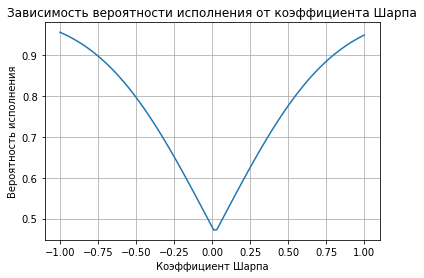

In [27]:
import matplotlib.pyplot as plt

sharpe_values = np.linspace(-1, 1, 100)
probabilities = []

for sharpe in sharpe_values:
    r = np.abs(sharpe - q)
    d1 = (np.log(S0 / K2) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
    probabilities.append(norm.cdf(d1))

plt.plot(sharpe_values, probabilities)
plt.title("Зависимость вероятности исполнения от коэффициента Шарпа")
plt.xlabel("Коэффициент Шарпа")
plt.ylabel("Вероятность исполнения")
plt.grid(True)
plt.show()
